# 1. Tiền xử lý dữ liệu

Tải các thư viện cần để xử lý dữ liệu

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import hashlib
import ast
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import random
from ast import literal_eval
from time import sleep
from datetime import datetime
from ast import literal_eval
import numpy as np
import csv
import os
import re

In [2]:
# Đọc file dữ liệu
read_df = pd.read_csv('Data/data.csv')

In [3]:
read_df = pd.read_csv('Data/data.csv',  encoding='ISO-8859-1')

In [4]:
read_df.info()
# ⇒ Dữ liệu chúng ta thu thập được sẽ có 863 bài post và có 80 cột dữ liệu được kéo về

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 80 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/bioLink                        0 non-null      float64
 2   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 3   authorMeta/digg                           863 non-null    int64  
 4   authorMeta/fans                           863 non-null    int64  
 5   authorMeta/following                      863 non-null    int64  
 6   authorMeta/friends                        863 non-null    int64  
 7   authorMeta/heart                          863 non-null    int64  
 8   authorMeta/id                             863 non-null    int64  
 9   authorMeta/name                           863 non-null    object 
 10  authorMeta/nickName                   

In [5]:
# Tiếp tục với quá trình xử lý dữ liệu, chúng ta sẽ xóa đi những cột có giá trị null hoàn toàn 
read_df = read_df.dropna(axis='columns', how='all')

In [6]:
# ⇒ Với cách này chúng ta đã loại bỏ đi được 2 cột dữ liệu không có giá trị phân tích 
# => Còn lại 78 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 78 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

In [7]:
# Tính tỷ lệ giá trị null cho mỗi cột
Null_Percentage = read_df.isnull().mean()

# Lấy các cột có tỷ lệ giá trị null lớn hơn 99%
Null_more_ninety = Null_Percentage[Null_Percentage > 0.99].index

# Xóa các cột có tỷ lệ giá trị null lớn hơn 99%
read_df = read_df.drop(columns=Null_more_ninety)

In [8]:
# ⇒ Với cách này chúng ta đã loại bỏ đi được 12 cột dữ liệu không có giá trị phân tích 
# => Còn 66 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 66 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

In [9]:
# Lấy các cột có tỷ lệ giá trị null lớn hơn 50% và bé hơn 99%
Null_Percentage[(Null_Percentage > 0.5) & (Null_Percentage < 0.99)].index

Index(['detailedMentions/0/id', 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1', 'videoMeta/subtitleLinks/0/downloadLink',
       'videoMeta/subtitleLinks/0/language',
       'videoMeta/subtitleLinks/0/tiktokLink'],
      dtype='object')

## **Xóa các cột chứa đường link**

## 1. Cột 'videoMeta/subtitleLinks/0/tiktokLink'

In [10]:
# # Ở đây chúng ta sẽ có một số các cột chứa các đường link,
# #  chúng ta sẽ kiểm tra xem các đường link đó có truy cập được không nếu không thì chúng ta sẽ xóa nó đi 


import pandas as pd
import hashlib
import numpy as np
import httpx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Hàm kiểm tra link
def check_link(link, expected_hash_value):
    try:
        with httpx.Client(timeout=5) as client:
            response = client.get(link)
        if response.status_code == 200:
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            if sha256_hash == expected_hash_value:
                return link
    except (httpx.RequestError, httpx.TimeoutException):
        pass
    return np.nan

# Hàm xử lý song song với tiến trình
def process_links(links, expected_hash_value):
    with ThreadPoolExecutor(max_workers=min(10, len(links))) as executor:
        results = list(tqdm(executor.map(lambda link: check_link(link, expected_hash_value), links), total=len(links)))
    return results

# Lọc các giá trị hợp lệ
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
valid_links = read_df['videoMeta/subtitleLinks/0/tiktokLink'].dropna()

# Xử lý các giá trị hợp lệ
processed_links = process_links(valid_links, expected_hash_value)

# Tạo một bản sao cột để lưu kết quả
processed_column = read_df['videoMeta/subtitleLinks/0/tiktokLink'].copy()

# Gán kết quả đã xử lý vào đúng vị trí
processed_column.loc[valid_links.index] = processed_links

# Cập nhật cột trong DataFrame
read_df['videoMeta/subtitleLinks/0/tiktokLink'] = processed_column

# Kiểm tra và loại bỏ cột nếu cần
if not read_df['videoMeta/subtitleLinks/0/tiktokLink'].isna().all():
    read_df.drop(columns=['videoMeta/subtitleLinks/0/tiktokLink'], inplace=True)


100%|██████████| 408/408 [01:03<00:00,  6.45it/s]


In [11]:
columns_to_drop = ['videoMeta/subtitleLinks/0/tiktokLink', 'videoMeta/subtitleLinks/0/tiktokLink_valid']
read_df = read_df.drop(columns=[col for col in columns_to_drop if col in read_df.columns])

In [12]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 65 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

## 2. Cột 'videoMeta/subtitleLinks/0/downloadLink'

In [13]:
print(read_df.columns.tolist())

['ï»¿"authorMeta/avatar"', 'authorMeta/commerceUserInfo/commerceUser', 'authorMeta/digg', 'authorMeta/fans', 'authorMeta/following', 'authorMeta/friends', 'authorMeta/heart', 'authorMeta/id', 'authorMeta/name', 'authorMeta/nickName', 'authorMeta/originalAvatarUrl', 'authorMeta/privateAccount', 'authorMeta/profileUrl', 'authorMeta/region', 'authorMeta/signature', 'authorMeta/ttSeller', 'authorMeta/verified', 'authorMeta/video', 'collectCount', 'commentCount', 'createTime', 'createTimeISO', 'detailedMentions/0/id', 'detailedMentions/0/nickName', 'detailedMentions/0/profileUrl', 'detailedMentions/1/id', 'detailedMentions/1/name', 'detailedMentions/1/nickName', 'detailedMentions/1/profileUrl', 'diggCount', 'hashtags/0/name', 'hashtags/1/name', 'hashtags/2/name', 'hashtags/3/name', 'hashtags/4/name', 'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'id', 'input', 'isPinned', 'isSlideshow', 'isSponsored', 'mentions/0', 'mentions/1', 'musicMeta/coverMediumUrl', 'musicMeta/musicAuthor'

In [14]:
import pandas as pd
import hashlib
import numpy as np
import httpx
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

# Hàm kiểm tra link
def check_link(link, expected_hash_value):
    try:
        with httpx.Client(timeout=5) as client:
            response = client.get(link)
        if response.status_code == 200:
            sha256_hash = hashlib.sha256(link.encode()).hexdigest()
            if sha256_hash == expected_hash_value:
                return link
    except (httpx.RequestError, httpx.TimeoutException):
        pass
    return np.nan

# Hàm xử lý song song với tiến trình
def process_links(links, expected_hash_value):
    with ThreadPoolExecutor(max_workers=min(10, len(links))) as executor:
        results = list(tqdm(executor.map(lambda link: check_link(link, expected_hash_value), links), total=len(links)))
    return results

# Lọc các giá trị hợp lệ
expected_hash_value = "098f6bcd4621d373cade4e832627b4f6"
valid_links = read_df['videoMeta/subtitleLinks/0/downloadLink'].dropna()

# Xử lý các giá trị hợp lệ
processed_links = process_links(valid_links, expected_hash_value)

# Tạo một bản sao cột để lưu kết quả
processed_column = read_df['videoMeta/subtitleLinks/0/downloadLink'].copy()

# Gán kết quả đã xử lý vào đúng vị trí
processed_column.loc[valid_links.index] = processed_links

# Cập nhật cột trong DataFrame
read_df['videoMeta/subtitleLinks/0/downloadLink'] = processed_column

# Kiểm tra và loại bỏ cột nếu cần
if not read_df['videoMeta/subtitleLinks/0/downloadLink'].isna().all():
    read_df.drop(columns=['videoMeta/subtitleLinks/0/downloadLink'], inplace=True)


100%|██████████| 408/408 [01:16<00:00,  5.33it/s]


In [15]:
# ⇒ Kết quả của cột này vẫn là False ⇒ Xóa cột này đi 

columns_to_drop = ['videoMeta/subtitleLinks/0/downloadLink', 'videoMeta/subtitleLinks/0/downloadLink_valid']
read_df = read_df.drop(columns=[col for col in columns_to_drop if col in read_df.columns])

In [16]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 64 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

## 3. Đối với các cột khác chúng ta sẽ kiểm tra dữ liệu của từng cột và đánh giá xem dữ liệu trong cột đó có sử dụng được hay có giá trị hay không

Dựa vào Index(['detailedMentions/0/id', 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1',
       'videoMeta/subtitleLinks/0/language',],
      dtype='object')

In [17]:
read_df['detailedMentions/0/id'].dropna().head(200)

# Dữ liệu ở cột này không có giá trị phân tích => Cột này sẽ bị xóa
read_df = read_df.drop(columns = 'detailedMentions/0/id')

In [18]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 63 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   ï»¿"authorMeta/avatar"                    863 non-null    object 
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool   
 2   authorMeta/digg                           863 non-null    int64  
 3   authorMeta/fans                           863 non-null    int64  
 4   authorMeta/following                      863 non-null    int64  
 5   authorMeta/friends                        863 non-null    int64  
 6   authorMeta/heart                          863 non-null    int64  
 7   authorMeta/id                             863 non-null    int64  
 8   authorMeta/name                           863 non-null    object 
 9   authorMeta/nickName                       863 non-null    object 
 10  authorMeta/originalAvatarUrl          

**Tương tự với các cột 'detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 'detailedMentions/1/id',
       'detailedMentions/1/name', 'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 'hashtags/7/name', 'mentions/0',
       'mentions/1',**

In [19]:
coloumns_drop_many = ['detailedMentions/0/nickName',
       'detailedMentions/0/profileUrl', 
       'detailedMentions/1/id',
       'detailedMentions/1/name', 
       'detailedMentions/1/nickName',
       'detailedMentions/1/profileUrl', 
       'hashtags/3/name', 'hashtags/4/name',
       'hashtags/5/name', 'hashtags/6/name', 
       'hashtags/7/name', 'mentions/0',
       'mentions/1',
       'videoMeta/subtitleLinks/0/language']

read_df = read_df.drop(columns=coloumns_drop_many)

In [20]:
# => Còn 49 cột
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 49 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   ï»¿"authorMeta/avatar"                    863 non-null    object
 1   authorMeta/commerceUserInfo/commerceUser  863 non-null    bool  
 2   authorMeta/digg                           863 non-null    int64 
 3   authorMeta/fans                           863 non-null    int64 
 4   authorMeta/following                      863 non-null    int64 
 5   authorMeta/friends                        863 non-null    int64 
 6   authorMeta/heart                          863 non-null    int64 
 7   authorMeta/id                             863 non-null    int64 
 8   authorMeta/name                           863 non-null    object
 9   authorMeta/nickName                       863 non-null    object
 10  authorMeta/originalAvatarUrl              863 non-

In [21]:
read_df["ï»¿\"authorMeta/avatar\""].dropna().head(200)
#Dữ liệu dẫn đến link avatar của chủ sở hữu
# => Xóa
read_df = read_df.drop(columns="ï»¿\"authorMeta/avatar\"")

In [22]:
read_df["authorMeta/commerceUserInfo/commerceUser"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị False
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="authorMeta/commerceUserInfo/commerceUser")

In [23]:
read_df["authorMeta/digg"].dropna().head(200)
#Dữ liệu chỉ toàn giá trị 0
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="authorMeta/digg")

In [24]:
#Loại bỏ các cột có dữ liệu bất biến
for col in read_df.columns:
    if read_df[col].nunique() == 1:
        read_df = read_df.drop(columns=col)

read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 25 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   collectCount                      863 non-null    int64 
 1   commentCount                      863 non-null    int64 
 2   createTime                        863 non-null    int64 
 3   createTimeISO                     863 non-null    object
 4   diggCount                         863 non-null    int64 
 5   hashtags/0/name                   835 non-null    object
 6   hashtags/1/name                   813 non-null    object
 7   hashtags/2/name                   674 non-null    object
 8   id                                863 non-null    int64 
 9   musicMeta/coverMediumUrl          863 non-null    object
 10  musicMeta/musicAuthor             863 non-null    object
 11  musicMeta/musicId                 863 non-null    int64 
 12  musicMeta/musicName   

In [25]:
coloumns_drop_many = ['musicMeta/coverMediumUrl','musicMeta/musicId',
                      'musicMeta/musicName','musicMeta/originalCoverMediumUrl','musicMeta/playUrl']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag musicMeta
read_df = read_df.drop(columns=coloumns_drop_many)

In [26]:
coloumns_drop_many = ['videoMeta/coverUrl','videoMeta/definition',
                      'videoMeta/height','videoMeta/originalCoverUrl','videoMeta/width']
#Tương tự với các cột có dữ liệu không thể phân tích được của tag videoMeta
read_df = read_df.drop(columns=coloumns_drop_many)

In [27]:
read_df["id"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="id")

In [28]:
read_df["webVideoUrl"].dropna().head(200)
#Dữ liệu là các con số
# => Xóa vì không có giá trị phân tích
read_df = read_df.drop(columns="webVideoUrl")

In [29]:
read_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   collectCount           863 non-null    int64 
 1   commentCount           863 non-null    int64 
 2   createTime             863 non-null    int64 
 3   createTimeISO          863 non-null    object
 4   diggCount              863 non-null    int64 
 5   hashtags/0/name        835 non-null    object
 6   hashtags/1/name        813 non-null    object
 7   hashtags/2/name        674 non-null    object
 8   musicMeta/musicAuthor  863 non-null    object
 9   playCount              863 non-null    int64 
 10  shareCount             863 non-null    int64 
 11  text                   862 non-null    object
 12  videoMeta/duration     863 non-null    int64 
dtypes: int64(7), object(6)
memory usage: 87.8+ KB


Chuyển dữ liệu thời gian về định dạng chuẩn

In [30]:
from datetime import datetime
from dateutil import parser
import pytz
vietnam_tz = pytz.timezone("Asia/Ho_Chi_Minh")
read_df['createTimeISO'] = read_df['createTimeISO'].astype(str)
read_df['createTimeISO'] = read_df['createTimeISO'].apply(
    lambda x: parser.isoparse(x).astimezone(vietnam_tz)
)
read_df['createTimeISO'] = read_df['createTimeISO'].astype(str)

read_df['createTimeISO'] = read_df['createTimeISO'].apply(
    lambda x: datetime.fromisoformat(x).astimezone(vietnam_tz)
)
read_df['date'] = read_df['createTimeISO'].apply(lambda x: x.date())  # Chỉ lấy ngày
read_df['hour'] = read_df['createTimeISO'].apply(lambda x: x.hour)   # Chỉ lấy giờ
read_df['year'] = read_df['date'].apply(lambda x: x.year)
read_df['month'] = read_df['date'].apply(lambda x: x.month)
read_df['day'] = read_df['date'].apply(lambda x: x.day)
read_df.drop(columns=['createTimeISO', 'date'])


,collectCount,commentCount,createTime,diggCount,hashtags/0/name,hashtags/1/name,hashtags/2/name,musicMeta/musicAuthor,playCount,shareCount,text,videoMeta/duration,hour,year,month,day
0,1392,231,1732165470,26900,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,499600,299,4 Vá» TÆ°á»ng CÃºi Äáº§u TrÆ°á»c 1 Vá» Tr...,108,12,2024,11,21
1,275,45,1731913011,3128,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,33600,203,Lá»ch Sá»­ NgÃ y NhÃ GiÃ¡o Viá»t Nam 20/11....,47,13,2024,11,18
2,184,34,1731554729,3192,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,36300,31,Chiáº¿c MÅ© Huyá»n Thoáº¡i Cá»§a Ãng Cha. ...,87,10,2024,11,14
3,691,226,1731216293,17700,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,305200,176,"Máº¹ Thá»©, HÆ¡n Cáº£ Sá»± VÄ© Äáº¡i ... #...",75,12,2024,11,10
4,1544,708,1730886398,38300,dongmauviet,NaN,NaN,DÃ²ng MÃ¡u Viá»t,1000000,364,PhÃ©p MÃ u Viá»t Nam ... #dongmauviet,88,16,2024,11,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,641,2285,1621612142,150200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,1300000,1064,Má»i ngÆ°á»i vÃ o kÃªnh youtube : dÃ²ng mÃ¡u...,107,22,2021,5,21
859,125,282,1621556153,16200,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,145000,155,Xin má»i ngÆ°á»i 1 bÃ¬nh luáº­n Äá» kÃªnh ...,159,7,2021,5,21
860,407,1195,1621471433,73700,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,434800,293,Xin má»i ngÆ°á»i 1 cháº¥m vÃ o bÃ¬nh luáº­n ...,68,7,2021,5,20
861,248,77,1621385927,14000,dongmauviet,lichsuvietnam,vietnam,DÃ²ng MÃ¡u Viá»t,139000,138,Má»i ngÆ°á»i cho mÃ¬nh xin 1 cháº¥m vÃ o bÃ¬...,58,7,2021,5,19


Tạo cột text_lenght bao gồm số lượng kí tự của text

In [31]:
read_df['text']=read_df['text'].astype(str)
read_df['text_length']=read_df['text'].apply(lambda x: len(list(x.split(" "))))

Chỉnh text về lỗi về đúng định dạng chữ tiếng Việt

In [32]:
read_df['text']= read_df['text'].apply(lambda x: x.encode('latin1').decode('utf-8'))
read_df['text'].dropna().head(200)

0      4 Vị Tướng Cúi Đầu Trước 1 Vị Trung Tá.   #don...
1      Lịch Sử Ngày Nhà Giáo Việt Nam 20/11.  #dongma...
2      Chiếc Mũ Huyền Thoại Của Ông Cha.   #dongmauviet 
3          Mẹ Thứ, Hơn Cả Sự Vĩ Đại ...    #dongmauviet 
4                  Phép Màu Việt Nam ...   #dongmauviet 
                             ...                        
195          #dongmauviet #dcgr #vietnam #lichsuvietnam 
196          #dongmauviet #dcgr #vietnam #lichsuvietnam 
197                         #dongmauviet #dcgr #vietnam 
198          #dongmauviet #dcgr #vietnam #lichsuvietnam 
199                         #dongmauviet #dcgr #vietnam 
Name: text, Length: 200, dtype: object

# II. Phân tích dữ liệu

## 1. Về xu hướng đăng bài của tài khoản

### 1.2 Khung giờ đăng bài trong ngày 

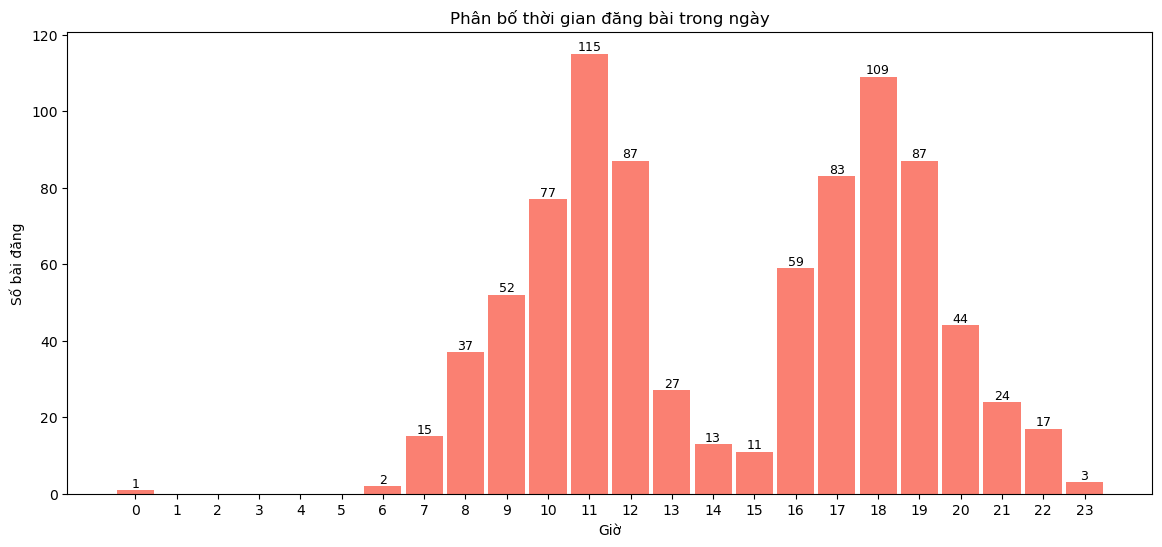

In [33]:
fig, time = plt.subplots(figsize=(14, 6))
time.hist(read_df['hour'], bins=np.arange(0, 25, 1), color='salmon', rwidth=0.9,align='left')
time.set_xticks(range(0, 24))
time.set_xlabel('Giờ')
time.set_ylabel('Số bài đăng')
time.set_title('Phân bố thời gian đăng bài trong ngày')
for patch in time.patches:
    height = patch.get_height()
    if height > 0:
        time.text(patch.get_x() + patch.get_width() / 2,
                  height,
                  int(height),
                  ha='center', va='bottom', fontsize=9, color='black')
plt.show()


Từ dữ biểu đồ trên, ta dễ dàng có thể thấy 2 khung giờ đăng bài phổ biến nhất là từ 10 - 12h và từ 17 - 19h. Đây là các thời gian nghỉ trưa, nghỉ buổi chiều của đa số mọi người, khung giờ dễ lấy được tương tác là thời gian mọi người rảnh để có thể vào xem.

### 1.3 Thời lượng video 

In [34]:
# Trung bình độ dài video:
Median = read_df["videoMeta/duration"].median()
Mean = read_df["videoMeta/duration"].mean()
print("Trung bình thời lượng video là: " + str(float(Median)))
print("Trung vị độ dài video là: "+ str(float(Mean)))

Trung bình thời lượng video là: 79.0
Trung vị độ dài video là: 112.70683661645423


In [35]:
#Độ dài tối thiểu, tối đa:
Max_video = read_df['videoMeta/duration'].max()
Min_video = read_df['videoMeta/duration'].min()

Standard_deviation = read_df['videoMeta/duration'].std()
print("Độ dài video tối thiểu là: " + str(float(Min_video)))
print("Độ dài video tối đa là: " + str(float(Max_video)))
print("Độ lệch chuẩn: " + str(float(Standard_deviation)))

Độ dài video tối thiểu là: 7.0
Độ dài video tối đa là: 597.0
Độ lệch chuẩn: 96.07552634751077


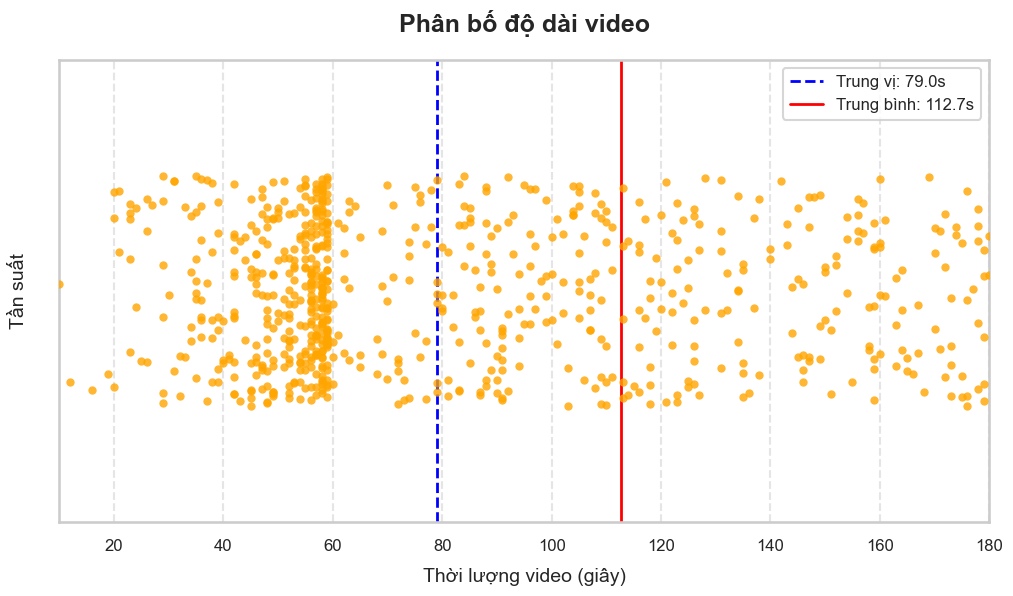

In [128]:
plt.figure(figsize=(12, 6))  
sns.set_theme(style="whitegrid", context="talk")

sns.stripplot(
    data=read_df, 
    x="videoMeta/duration", 
    color="orange", 
    jitter=0.25,         
    size=6,              
    alpha=0.8            
)


plt.axvline(Median, color='blue', linestyle='--', label=f'Trung vị: {Median:.1f}s', linewidth=2)
plt.axvline(Mean, color='red', linestyle='-', label=f'Trung bình: {Mean:.1f}s', linewidth=2)

plt.title("Phân bố độ dài video", fontsize=18, fontweight='bold', pad=20)
plt.xlabel("Thời lượng video (giây)", fontsize=14, labelpad=10)
plt.ylabel("Tần suất", fontsize=14, labelpad=10)

plt.xticks(fontsize=12, rotation=0)  
plt.yticks(fontsize=12)
plt.xlim(10, 180)  

# Chú thích
plt.legend(fontsize=12, loc='upper right')

# Thêm lưới nhẹ
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.show()


Ta có thể thấy rằng thời lượng video được phân bố khá đều từ khoảng 10 giây đến 180 giây. Trong đó với trung vị khoảng 79.0s và giá trị tủng bình khoảng 112.7s 
=> Đây là đặc trưng thời lượng video của ứng dụng giải trí nhanh giúp người xem dễ dàng tiếp thu kiến thức qua các video ngắn, dễ hiểu, dễ nhớ

Thêm vào đó, dựa vào biểu đồ, xu hướng up video của kênh thường tập trung nhiều vào các video dài 40s-60s, đây là khoảng thời gian lý tưởng để tối ưu hóa nội dung cho người xem khi xem một video về lịch sử



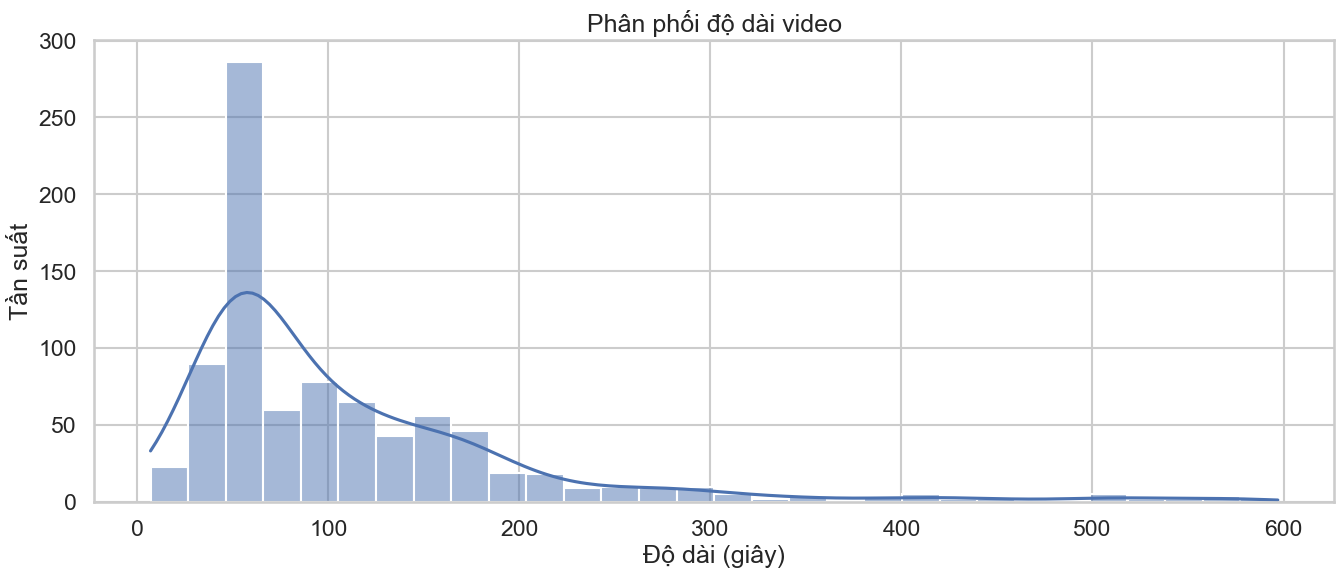

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 6))  
sns.set_theme(style="whitegrid", context="talk")
# Biểu đồ phân phối
sns.histplot(read_df["videoMeta/duration"], bins=30, kde=True)
plt.title('Phân phối độ dài video')
plt.xlabel('Độ dài (giây)')
plt.ylabel('Tần suất')
plt.show()

Dựa vào biểu đồ ta có thể thấy rằng: Khi độ dài video tăng (lớn hơn 100 giây), tần suất giảm dần, cho thấy ít video có thời lượng dài hơn. Bên cạnh đó, phân phối có xu hướng lệch phải, đặc trưng bởi số lượng lớn các video ngắn và giảm dần khi độ dài tăng lên.

**Tổng quan thời lượng video qua các ngày**

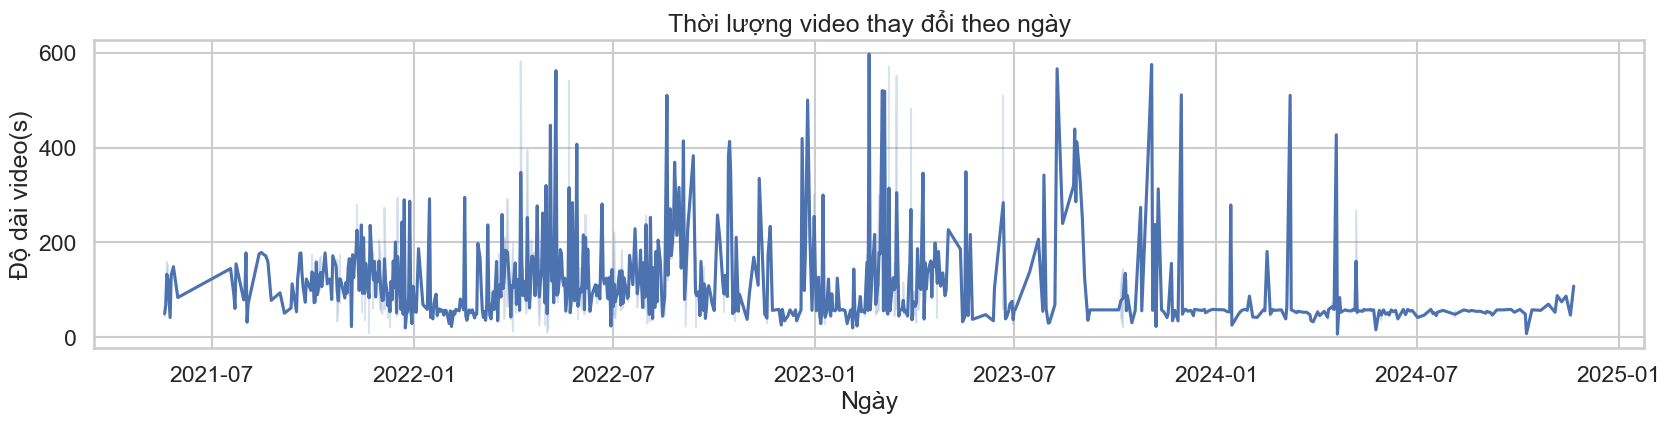

In [38]:
plt.figure(figsize=(20,4))
sns.lineplot(data = read_df, x = read_df['date'], y= read_df['videoMeta/duration'])
plt.title('Thời lượng video thay đổi theo ngày')
plt.xlabel('Ngày')
plt.ylabel('Độ dài video(s)')
plt.show()

Từ năm 2022-2023, thời lượng của video khá lớn và giữ vững giá trị tủng bình, tuy nhiên đến năm 2024, tần suất dài của video giảm mạnh dù vẫn đạt các cột mốc lượng trung bình của video tăng mạnh

**Phân tích độ dài video theo thời gian**

**Theo ngày**

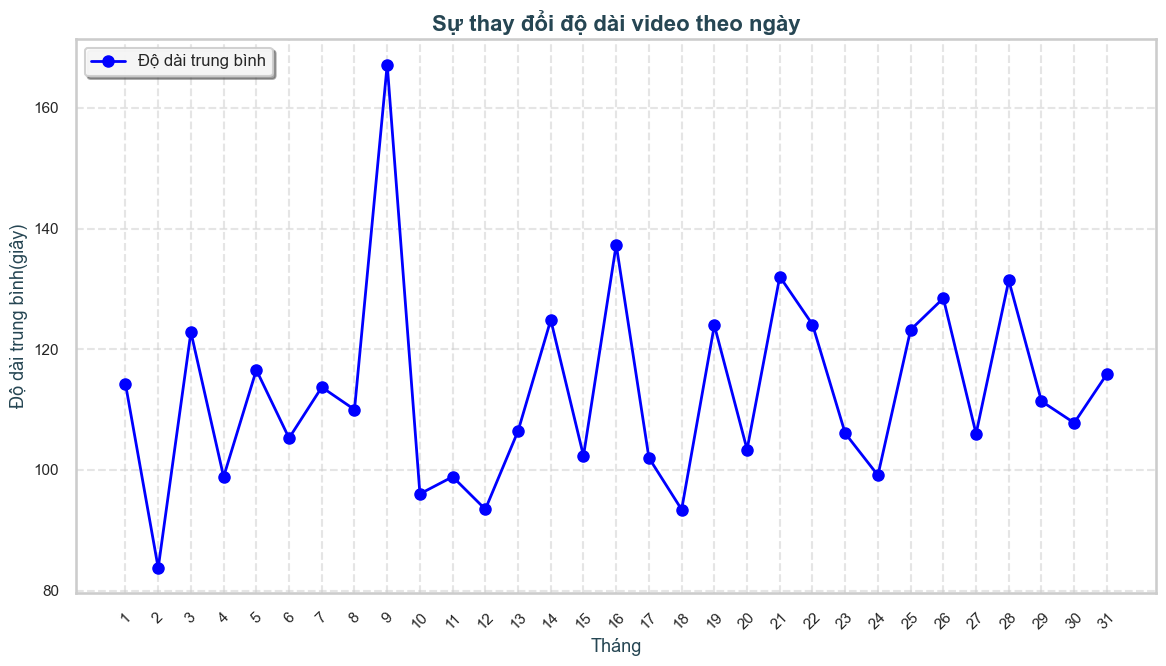

In [39]:
avgl_month = (read_df.groupby('day')['videoMeta/duration'].mean().reset_index(name='avgl_day'))

sns.set_style('whitegrid')  
palette = sns.color_palette('coolwarm', n_colors=len(avgl_month))  

plt.figure(figsize=(12, 7))  
plt.plot(
    avgl_month['day'].astype(str),  
    avgl_month['avgl_day'],  
    marker='o',  
    linestyle='-',  
    linewidth=2,  
    markersize=8,  
    color='blue',  
    label='Độ dài trung bình'
)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.title('Sự thay đổi độ dài video theo ngày', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Tháng', fontsize=13, color='#264653')
plt.ylabel('Độ dài trung bình(giây)', fontsize=13, color='#264653')
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
plt.tight_layout()
plt.show()

Dựa vào biểu đồ, độ dài trung bình của video có nhiều biến động lên xuống, trong đó tăng mạnh và đạt đỉnh vào ngày 9 hàng tháng

**Theo tháng**

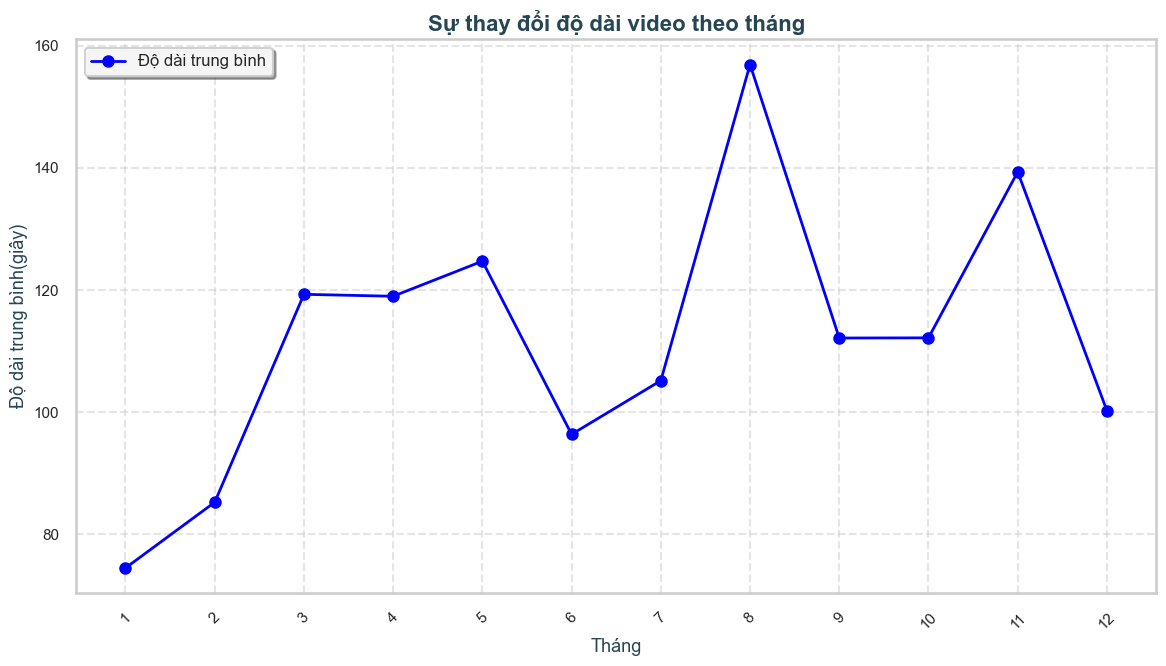

In [40]:
avgl_month = (read_df.groupby('month')['videoMeta/duration'].mean().reset_index(name='avgl_month'))

sns.set_style('whitegrid')  
palette = sns.color_palette('coolwarm', n_colors=len(avgl_month))  

plt.figure(figsize=(12, 7))  
plt.plot(
    avgl_month['month'].astype(str),  
    avgl_month['avgl_month'],  
    marker='o',  
    linestyle='-',  
    linewidth=2,  
    markersize=8,  
    color='blue',  
    label='Độ dài trung bình'
)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.title('Sự thay đổi độ dài video theo tháng', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Tháng', fontsize=13, color='#264653')
plt.ylabel('Độ dài trung bình(giây)', fontsize=13, color='#264653')
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
plt.tight_layout()
plt.show()

Dựa vào biểu đồ, thời lượng video tăng nhanh đột biến vào khoảng tháng 4, tháng 8 và tháng 11, đây là thời điểm trong năm có các sự kiện lịch sử lớn của dân tộc như Giải phóng miền Nam, Thống nhất đất nước (30/4), Cách Mạng tháng Tám thành công,...

Trong các tháng như tháng 6 và tháng 12, kênh tập trung vào nội dung ngắn gọn, phù hợp hơn với thị hiếu thời điểm đó.

**Theo năm**

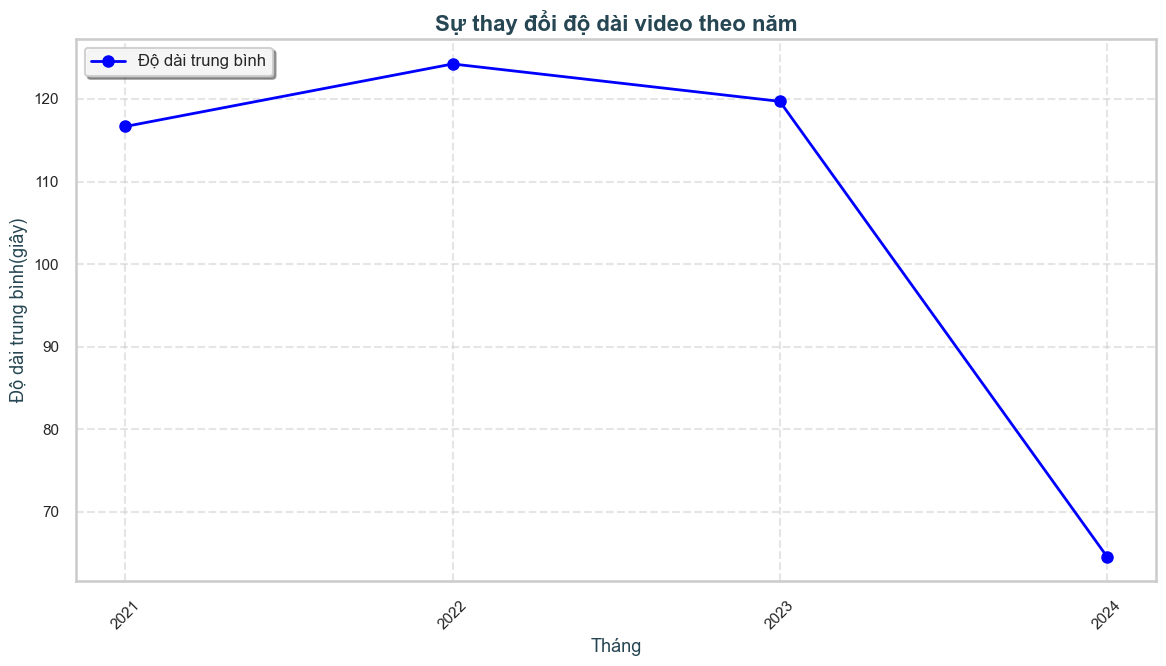

In [41]:
avgl_month = (read_df.groupby('year')['videoMeta/duration'].mean().reset_index(name='avgl_year'))

sns.set_style('whitegrid')  
palette = sns.color_palette('coolwarm', n_colors=len(avgl_month))  

plt.figure(figsize=(12, 7))  
plt.plot(
    avgl_month['year'].astype(str),  
    avgl_month['avgl_year'],  
    marker='o',  
    linestyle='-',  
    linewidth=2,  
    markersize=8,  
    color='blue',  
    label='Độ dài trung bình'
)

plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)
plt.title('Sự thay đổi độ dài video theo năm', fontsize=16, fontweight='bold', color='#264653')
plt.xlabel('Tháng', fontsize=13, color='#264653')
plt.ylabel('Độ dài trung bình(giây)', fontsize=13, color='#264653')
plt.grid(True, linestyle='--', alpha=0.5)  
plt.legend(fontsize=12, loc='upper left', frameon=True, framealpha=0.9, shadow=True)
plt.tight_layout()
plt.show()

Nhìn chung, trung bình độ dài video của kênh tăng và đạt đỉnh tại năm 2022, sau đó giảm nhẹ vào năm 2023 và giảm mạnh vào năm 2024

**Dạng Barplot**

In [42]:
video_duration_by_week = pd.DataFrame()
video_duration_by_week['Week'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%W')
video_duration_by_week = video_duration_by_week.sort_values('Week')
video_duration_by_week = video_duration_by_week.groupby('Week').size().reset_index(name='Video Duration')

video_duration_by_month = pd.DataFrame()
video_duration_by_month['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%m')
video_duration_by_month = video_duration_by_month.sort_values('Month')
video_duration_by_month = video_duration_by_month.groupby('Month').size().reset_index(name='Video Duration')

video_duration_by_year = pd.DataFrame()
video_duration_by_year['Year'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y')
video_duration_by_year = video_duration_by_year.sort_values('Year')
video_duration_by_year = video_duration_by_year.groupby('Year').size().reset_index(name='Video Duration')


Text(0.5, 1.0, 'Video Duration by Year')

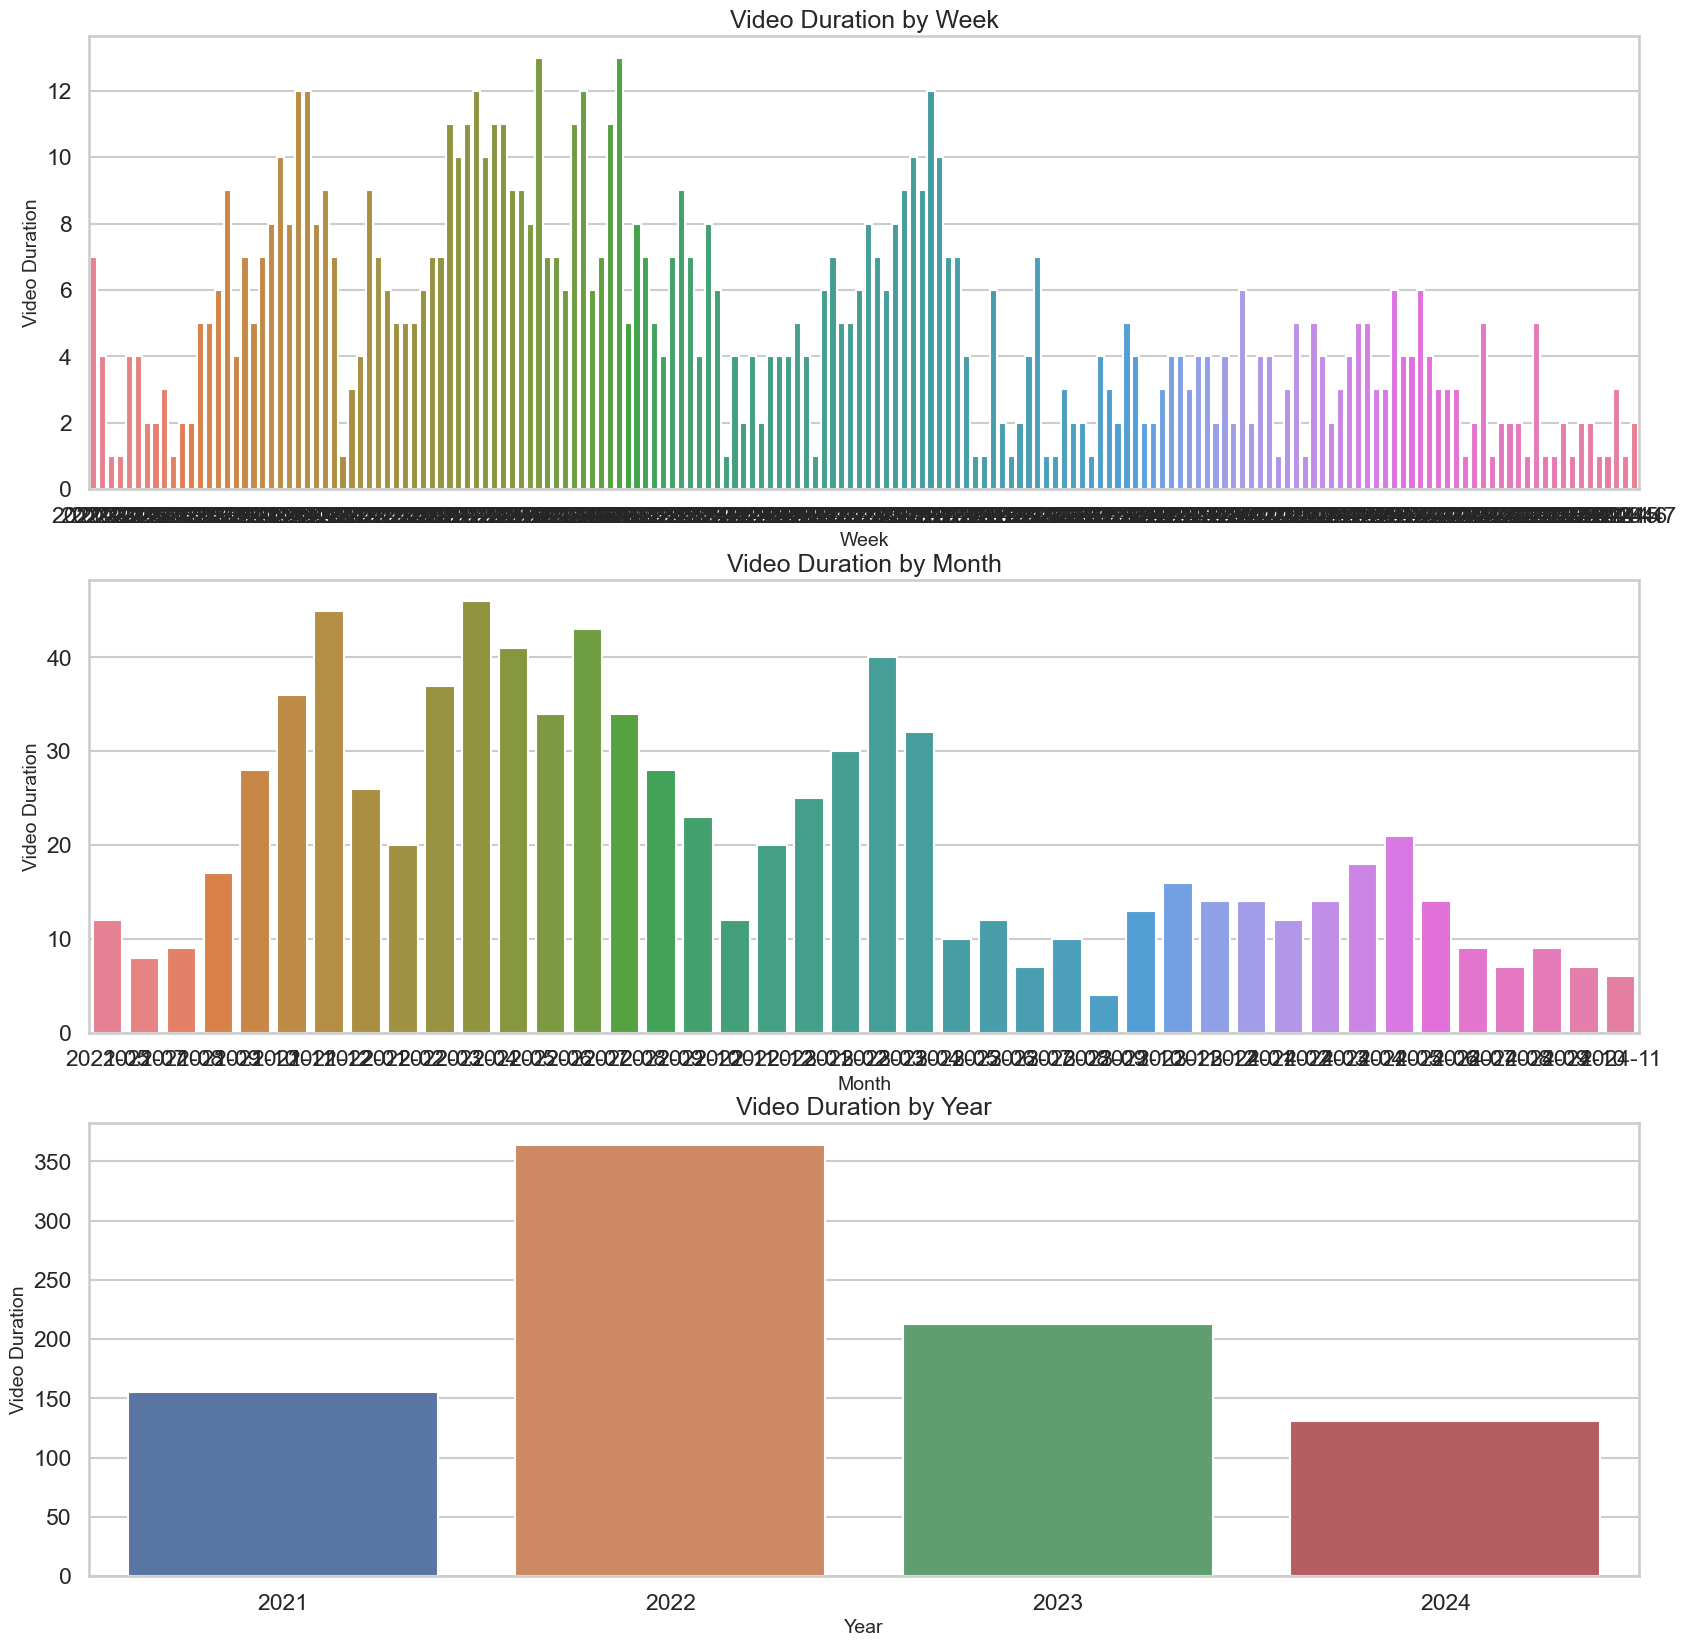

In [43]:
fig, axes = plt.subplots(3,1,figsize = (20,20))
sns.barplot(data= video_duration_by_week, x = 'Week', y='Video Duration', ax=axes[0], hue = 'Week')
axes[0].set_xlabel('Week', fontsize = 14)
axes[0].set_ylabel('Video Duration', fontsize = 14)
axes[0].set_title('Video Duration by Week', fontsize =18)

sns.barplot(data= video_duration_by_month, x = 'Month', y='Video Duration', ax=axes[1], hue = 'Month')
axes[1].set_xlabel('Month', fontsize = 14)
axes[1].set_ylabel('Video Duration', fontsize = 14)
axes[1].set_title('Video Duration by Month', fontsize =18)

sns.barplot(data= video_duration_by_year, x ='Year', y='Video Duration', ax=axes[2], hue = 'Year')
axes[2].set_xlabel('Year', fontsize = 14)
axes[2].set_ylabel('Video Duration', fontsize = 14)
axes[2].set_title('Video Duration by Year', fontsize =18)


Ta có thể thấy rằng thời lượng video có xu hướng tăng mạnh vào năm 2022 và giảm dần về sau nhưng vẫn duy trì khá ổn định

In [44]:
video_duration_contrb_by_year = pd.DataFrame()
video_duration_contrb_by_year['Month'] = pd.to_datetime(read_df['createTimeISO']).dt.strftime('%Y-%M')
video_duration_contrb_by_year['Year'] = read_df['year']
video_duration_contrb_by_year['Date'] = read_df['date']
video_duration_contrb_by_year['Video Duration'] = read_df['videoMeta/duration']

In [45]:
video_duration_contrb_by_year

,Month,Year,Date,Video Duration
0,2024-04,2024,2024-11-21,108
1,2024-56,2024,2024-11-18,47
2,2024-25,2024,2024-11-14,87
3,2024-24,2024,2024-11-10,75
4,2024-46,2024,2024-11-06,88
...,...,...,...,...
858,2021-49,2021,2021-05-21,107
859,2021-15,2021,2021-05-21,159
860,2021-43,2021,2021-05-20,68
861,2021-58,2021,2021-05-19,58


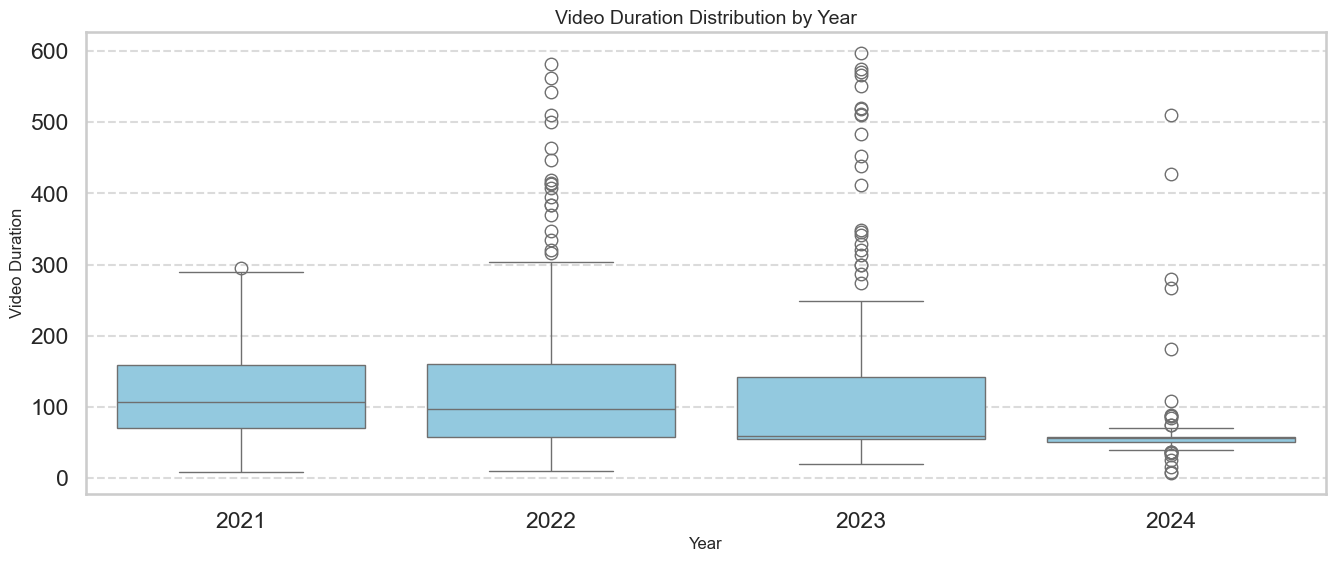

In [46]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='Year', y='Video Duration', data=video_duration_contrb_by_year, color='skyblue')

plt.title('Video Duration Distribution by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Video Duration', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)


Dựa vào biểu đồ, ta thấy rằng xu hướng thời lượng video:

Thời lượng video trung bình tăng cao trong 2022 và 2023, sau đó giảm đáng kể trong 2024.
Phân tán dữ liệu (IQR) lớn nhất trong 2022 và 2023, cho thấy sự đa dạng về thời lượng video trong giai đoạn này.
2024 có thời lượng video giảm mạnh, với dữ liệu ít phân tán hơn.
Ngoại lệ (Outliers):

Số lượng outliers lớn nhất trong 2022 và 2023, có thể do một số video có thời lượng bất thường.
2021 và 2024 có ít outliers hơn, với giá trị thời lượng thấp hơn.

### 1.4 Phân bố độ dài caption của video

In [47]:
read_df['text_length'].dropna().head(200)

0      14
1      11
2      11
3      13
4       9
       ..
195     5
196     5
197     4
198     5
199     4
Name: text_length, Length: 200, dtype: int64

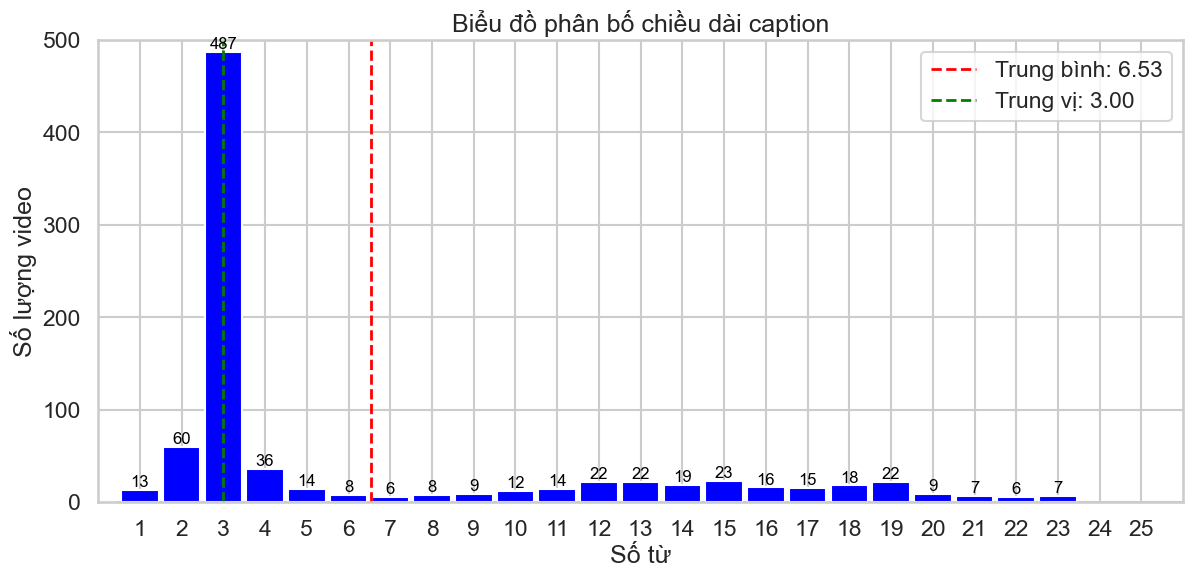

In [48]:

fig, text_length = plt.subplots(figsize=(14, 6))
text_length.hist(read_df['text_length'], bins=np.arange(0, 25, 1), color='blue', rwidth=0.9,align='left')
text_length.set_xlim(0,26)
text_length.set_ylim(0,500)
text_length.set_xticks(range(1,26,1))
text_length.set_xlabel('Số từ')
text_length.set_ylabel('Số lượng video')
text_length.set_title('Biểu đồ phân bố chiều dài caption')

for patch in text_length.patches:
    height = patch.get_height()
    if height > 0:
        text_length.text(patch.get_x() + patch.get_width() / 2,
                  height,
                  int(height),
                  ha='center', va='bottom', fontsize=12, color='black')
mean_value = read_df['text_length'].mean()
median_value = read_df['text_length'].median()
text_length.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Trung bình: {mean_value:.2f}')
text_length.axvline(median_value, color='green', linestyle='--', linewidth=2, label=f'Trung vị: {median_value:.2f}')
text_length.legend()
plt.show()

Chiều dài caption của các video hầu hết nằm trong khoảng 2 đến 4 kí tự với giá trị trung bình của độ dài là 6.53, giá trị trung vị là 3.00. Đây là giá trị phù hợp vì hầu hết các video tiktok cung cấp lượng lớn thông tin qua nội dung video, caption mang hàm lượng thông tin thấp, chủ yếu là chú thích và tóm tắt thêm cho nội dung video. Đây là xu hướng hiện tại của giới trẻ khi sẽ ưu tiên việc nghe nhiều hơn đọc.

## 2. Phân tích sự tương quan giữa các yếu tố

##### ## **2.1 Tổng quan chung về tương tác của tài khoản**

2.1.1 Lượng trung bình tương tác của kênh:

In [58]:
print('Trung bình lượt thích là: ' + str(read_df['diggCount'].mean()))
print('Trung bình lượt bình luận là: ' + str(read_df['commentCount'].mean()))
print('Trung bình lượt lưu lại là: ' + str(read_df['collectCount'].mean()))
print('Trung bình lượt chia sẻ là: ' + str(read_df['shareCount'].mean()))
print('Trung bình lượt phát là: ' + str(read_df['playCount'].mean()))

Trung bình lượt thích là: 70468.66164542294
Trung bình lượt bình luận là: 1099.9617612977984
Trung bình lượt lưu lại là: 1763.3047508690613
Trung bình lượt chia sẻ là: 697.106604866744
Trung bình lượt phát là: 1054663.3835457705


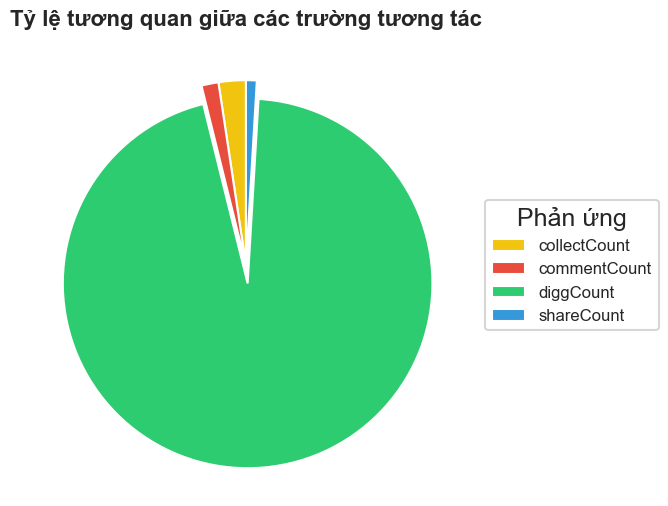

In [96]:
reaction_count = read_df[['collectCount', 'commentCount', 'diggCount', 'shareCount']].copy()

reactions = ['collectCount', 'commentCount', 'diggCount', 'shareCount']

read_df['ReactionCount'] = read_df['collectCount'] + read_df['commentCount'] + read_df['diggCount'] + read_df['shareCount']

reaction_sum = [read_df['collectCount'].sum(), read_df['commentCount'].sum(), read_df['diggCount'].sum(), read_df['shareCount'].sum() ]

mycolor = ['#f1c40f', '#e74c3c', '#2ecc71', '#3498db']  
plt.figure(figsize=(18, 6))
explode = (0, 0, 0.1, 0)  
plt.pie(reaction_sum, 
        colors=mycolor, 
        startangle=90, 
        explode=explode) 
plt.title('Tỷ lệ tương quan giữa các trường tương tác', fontsize=16, fontweight='bold')
plt.legend(reactions, 
           title="Phản ứng", 
           loc="center left", 
           bbox_to_anchor=(1, 0.5),  
           fontsize=12)


Dựa vào biểu đồ có thể thấy rõ rằng lượt like luôn chiếm đa phần trong trường tương tác của tài khoản, điều này thể hiện rõ xu hướng biểu hiện cảm xúc nhanh thông qua thả tim, thay vì các hành động khác như share, comment,........

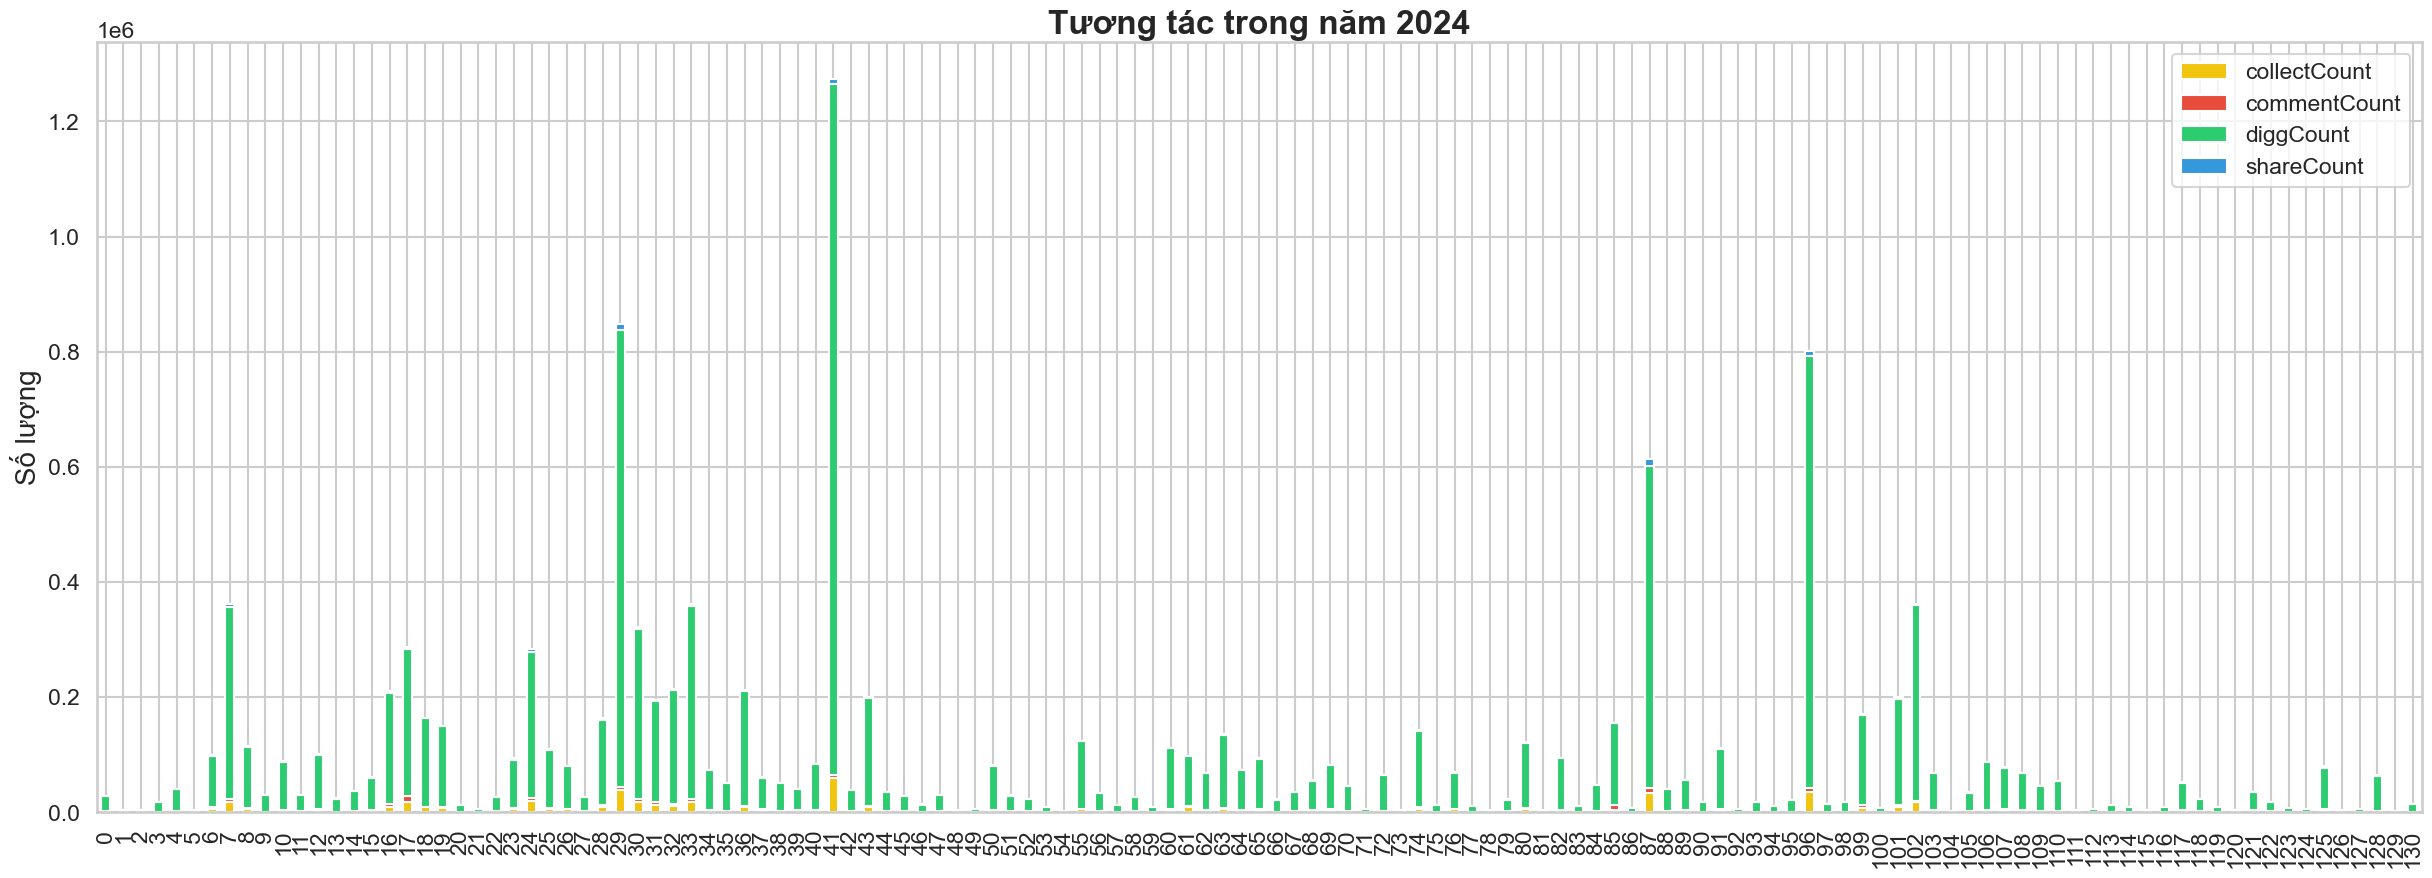

In [107]:
reaction_count_2024 = read_df[read_df['year'] == 2024][['collectCount', 'commentCount', 'diggCount', 'shareCount']]
reaction_count_2024.plot(kind='bar', stacked=True, figsize=(30, 10), color=['#f1c40f', '#e74c3c', '#2ecc71', '#3498db'])

plt.title('Tương tác trong năm 2024', fontsize=24, fontweight='bold')
plt.xlabel('', fontsize=20)
plt.ylabel('Số lượng', fontsize=20)

plt.show()

Lượt tương tác trong năm nhẩy vọt vào khoảng quý 2 sau đó giảm mạnh, duy trì , vọt lên vào cuối quý 3, đầu quý 4 trong năm, cho thấy xu hướng tương tác nhìn chung không có nhiều biến động nhưng giảm dần về cuối năm

##### **2.3 Tỉ lệ tương tác giữa các thứ trong tuần**

In [116]:
reaction_by_week = read_df[['collectCount', 'commentCount', 'diggCount', 'shareCount', 'playCount', 'createTimeISO']].copy()
reaction_by_week['rate of reaction'] = (reaction_by_week['diggCount'] + reaction_by_week['shareCount'] + reaction_by_week['commentCount'])/(reaction_by_week['playCount'])*100
reaction_by_week['day of week'] = reaction_by_week['createTimeISO'].dt.day_of_week

In [118]:
print('Độ lệch chuẩn là: ' + str(reaction_by_week['rate of reaction'].std()))
print('Phương sai: ' + str(reaction_by_week['rate of reaction'].var()))

Độ lệch chuẩn là: 2.47373249723896
Phương sai: 6.1193524678961


<Figure size 1500x600 with 0 Axes>

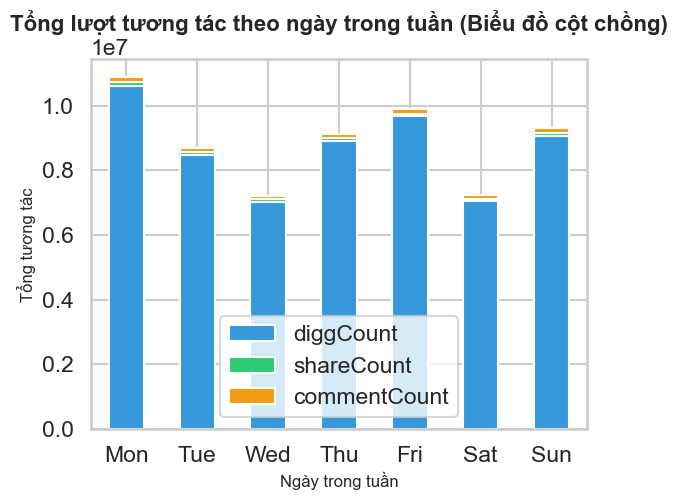

In [ ]:
reaction_by_week_grouped = reaction_by_week.groupby('day of week')[['diggCount', 'shareCount', 'commentCount']].sum()
plt.figure(figsize=(15, 6))
reaction_by_week_grouped.plot(kind='bar', stacked=True, color=['#3498db', '#2ecc71', '#f39c12'])
plt.title('Tổng lượt tương tác theo ngày trong tuần', fontsize=16, fontweight='bold')
plt.xlabel('Ngày trong tuần', fontsize=12)
plt.ylabel('Tổng tương tác', fontsize=12)
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
plt.show()


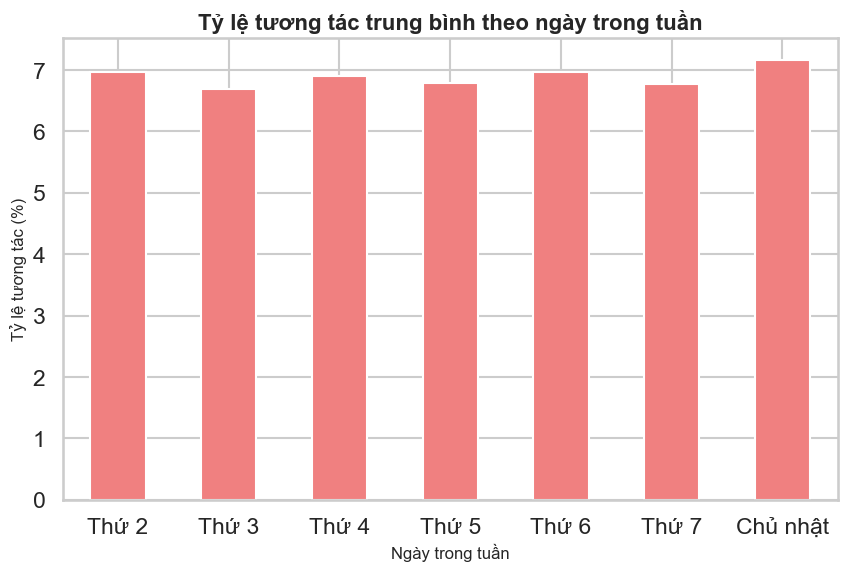

In [127]:
average_rate_by_week = reaction_by_week.groupby('day of week')['rate of reaction'].mean()

plt.figure(figsize=(10, 6)), average_rate_by_week.plot(kind='bar', color='#f08080')
plt.title('Tỷ lệ tương tác trung bình theo ngày trong tuần', fontsize=16, fontweight='bold')
plt.xlabel('Ngày trong tuần', fontsize=12)
plt.ylabel('Tỷ lệ tương tác (%)', fontsize=12)
plt.xticks(ticks=range(7), labels=['Thứ 2', 'Thứ 3', 'Thứ 4', 'Thứ 5', 'Thứ 6', 'Thứ 7', 'Chủ nhật'], rotation=0)
plt.show()




Tỉ lệ tương tác trong tuần rất ổn định, xấp xỉ 7%. Trong đó cao nhất là vào Chủ nhật, với lượt tương tác xấp xỉ 7,1%
Qua đó dễ dàng nhận định lượng tương tác vào cuối tuần hoặc đầu tuần thường có xu hướng cao hơn các ngày trong tuần

##### **2.4 Phân tích tương tác của tài khoản qua các comments trong các bài đăng**

## 3 Xây dựng mô hình dự đoán dựa trên PCA, Hồi quy tuyến tính, học máy

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data1= pd.DataFrame(read_df[['videoMeta/duration','hour','text_length']])
data1.info()

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data1)

# Áp dụng PCA
pca = PCA(n_components=2)  # Giảm xuống 2 thành phần chính
principal_components = pca.fit_transform(data_scaled)

# Xem tỷ lệ phương sai giải thích
print("Tỷ lệ phương sai giải thích của các thành phần chính:")
print(pca.explained_variance_ratio_)

# Hiển thị hệ số tải
loadings = pd.DataFrame(pca.components_, columns=['videoMeta/duration','hour','text_length'], index=['PC1', 'PC2'])
print("Hệ số tải (Loadings):")
print(loadings)

ModuleNotFoundError: No module named 'sklearn'